In [1]:
#IMPORTING ALL THE DEPENDENCIES FOR LOADING AND TRAINING THE MODEL
import keras
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.core import Dense,Flatten,Dropout
from keras.models import Model,load_model
from keras.layers import Input,add,BatchNormalization
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.callbacks import ModelCheckpoint


C:\Users\Pradeep\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#IMPORTING THE LIBRARIES FOR DATA-PRE_PROCESSING
import random
import os
from scipy.misc import imread,imshow,imresize


YOUNG


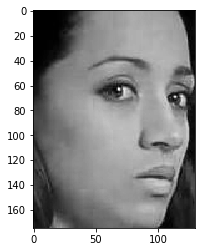

In [74]:
#PLOTTING A RANDOM IMAGE AND ITS LABEL FROM THE TRAINING SET
i=random.choice(train.index)
imgid=train.ID[i]
img=plt.imread(os.path.join('Train',imgid))
print(train.Class[i])
img=img[:,:,0]
img=img.astype('float32')/255
plt.imshow(img,cmap='gray')


In [8]:
#LOADING THE IMAGE IDs AND THEIR LABELS TO EXTRACT THE IMAGES FROM THE 'Train' AND 'Test' FOLDERS
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [ ]:
#CONVERTING ALL THE TRAINING IMAGES INTO GRAYSCALE AND THEN CONVERTING THEM INTO
#NUMPY ARRAYS OF SIZE (48,48) AND NORMALIZING THEM
temp=[]
for imgid in train.ID:
    image=os.path.join('Train',imgid)
    img=imread(image,'0')
    img=imresize(img,(48,48))
    img=img.astype('float32')/255.
    temp.append(img)
    
Xtrain=np.stack(temp)


In [107]:
#CONVERTING ALL THE TEST IMAGES INTO GRAYSCALE AND THEN CONVERTING 
#THEM INTO NUMPY ARRAYS OF SIZE (48,48) AND NORMALIZING THEM

temp=[]       
for imid in test.ID:
    image=os.path.join('Test',imid)
    img=imread(image,'0')
    img=imresize(img,(48,48))
    img=img.astype('float32')/255.
    temp.append(img)
Xtest=np.stack(temp) 

C:\Users\Pradeep\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\Pradeep\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [ ]:
#SAVING THE NUMPY ARRAYS 
np.save('traingrayimgs.npy',Xtrain)
np.save('testgrayimgs.npy',Xtest)

In [25]:
#LOADING THE TRAINING IMAGES AND THEIR LABELS 
Xtrain=np.load('traingrayimgs.npy')
Xtrain=Xtrain.reshape((19906,48,48,1))
Ytrain=train.iloc[:,1:].values

In [ ]:
#DATA-AUGMENTATION
Xfl = Xtrain[:, :, ::-1]  # simple slice to flip all images
Yfl=Ytrain
X=np.concatenate((Xtrain,Xfl),axis=0)
Y=np.concatenate((Ytrain,Yfl),axis=0)

#SPLITTING THE TRAINING SET INTO TRAINING AND VALIDATION SET
from sklearn.model_selection import train_test_split
Xtrain,Xval,Ytrain,Yval=train_test_split(X,Y,test_size=0.045,random_state=124)



In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
lb=LabelEncoder()
Ytrain=lb.fit_transform(Ytrain)
Ytrain=to_categorical(Ytrain)


MIDDLE
[1. 0. 0.]


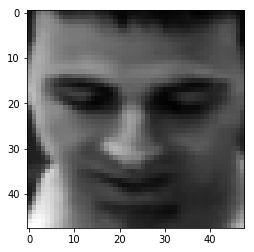

In [132]:
#LOOKING AT A RANDOM IMAGE AND ITS LABEL FROM THE TRAINING SET
j=np.random.randint(0,Xtrain.shape[0])
plt.imshow(Xtrain[j].reshape(48,48),cmap='gray')
print(train.Class[j])
print(Ytrain[j])

In [209]:
#DEFINING THE KERAS MODEL USING THE FUNCTIONAL-API
x=Input(shape=(48,48,1))
con1=Conv2D(8,(3,3),activation='relu')(x)
max1=MaxPooling2D( (2,2))(con1)
dr1=Dropout(0.05)(max1)
con2=Conv2D(16,(3,3),activation='relu')(dr1)
max2=MaxPooling2D((2,2))(con2)
con3=Conv2D(32,(3,3),activation='relu')(max2)
ba=BatchNormalization(epsilon=0.0002)(con3)
max3=MaxPooling2D((2,2))(ba)
flat=Flatten()(max3)
dens1=Dense(176,activation='relu')(flat)
dens2=Dense(72,activation='relu')(dens1)
op=Dense(3,activation='softmax')(dens2)

ages=Model(x,op)     

ages.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [210]:
ages.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 8)         80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 8)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 23, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 16)        1168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 32)          4640      
__________

In [212]:
#DEFINING A CALLBACK TO STOP OVERFITTING AND THE TRAINING THE DATASET
esm=EarlyStopping(monitor='val_loss',patience=4)

Hist=ages.fit(Xtrain,Ytrain,batch_size=32,epochs=20,validation_data=(Xval,Yval),callbacks=[esm])


Train on 38020 samples, validate on 1792 samples
Epoch 1/20
38020/38020 [==============================] - 23s 601us/step - loss: 0.4059 - acc: 0.8320 - val_loss: 0.6058 - val_acc: 0.7589
Epoch 2/20
38020/38020 [==============================] - 23s 601us/step - loss: 0.3722 - acc: 0.8486 - val_loss: 0.6215 - val_acc: 0.7545
Epoch 3/20
38020/38020 [==============================] - 23s 601us/step - loss: 0.3455 - acc: 0.8601 - val_loss: 0.6863 - val_acc: 0.7411
Epoch 4/20
38020/38020 [==============================] - 23s 601us/step - loss: 0.3166 - acc: 0.8745 - val_loss: 0.6824 - val_acc: 0.7578
Epoch 5/20
38020/38020 [==============================] - 23s 603us/step - loss: 0.2903 - acc: 0.8847 - val_loss: 0.6979 - val_acc: 0.7645


In [213]:
ages.save('agedec(25.6).h5')

In [4]:
new=load_model('agedec(25.6).h5')

In [20]:
#LOADING ALL THE TEST IMAGES FOR PREDICTION 
testimgs=np.load('testgrayimgs.npy')
testimgs=testimgs.reshape((6636,48,48,1))
testimgs.shape

(6636, 48, 48, 1)

The image shows a OLD-aged person.


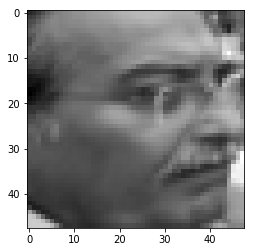

In [188]:
#PREDICTING THE LABEL ON A RANDOM IMAGE FROM THE TEST-SET

labels={0:'MIDDLE',1:'OLD',2:'YOUNG'}
i=random.choice(test.index)
imgid=test.ID[i]
plt.imshow(testimgs[i].reshape(48,48),cmap='gray')
y=np.expand_dims(testimgs[i],axis=0)
y=new.predict(y)
print('The image shows a {}-aged person.'.format(labels[np.argmax(y)]))
